<a href="https://colab.research.google.com/github/OlgaNezh/PyTorch/blob/main/CNN_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Фреймворк PyTorch для разработки искусственных нейронных сетей

Обучите CNN (самописная) на CIFAR-100.

Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

*Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.



In [2]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def train_eval_model(net, num_epochs, train_loader, valid_loader):
    for epoch in range(num_epochs):  
        net.train()
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обучение
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if i % 300 == 0:    # печатаем каждые 300 mini-batches
                net.eval()

                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}. ' \
                      f'Acc: {running_right / running_items:.3f}', end='. ')
                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(valid_loader):

                    test_outputs = net(data[0].to(device))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

                print(f'Test acc: {test_running_right / test_running_total:.3f}')

    print('Training is finished!')

In [5]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

dataset = datasets.CIFAR100(root='data/',
                            train=True, 
                            download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [6]:
classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm')

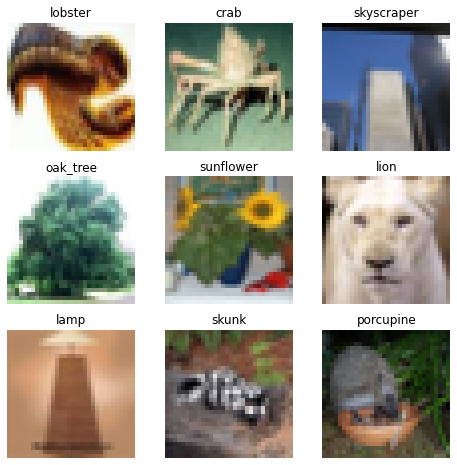

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [9]:
# разбиваем на train и test
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

#класс датасета
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]  #извлекаем картинку
        if self.transform is not None:
            img = self.transform(img)
        label = self._base_dataset[idx][1] #извлекаем класс
        return img, label

#преобразования датасета
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

In [10]:
#разбиваем датасет
train_dataset, valid_dataset = train_valid_split(dataset)

#формируем экземпляры классов (тензор, класс)
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())
print('Количество экземплятов в тренировочном датасете: ', len(train_dataset))
print('Количество экземплятов в валидационном датасете: ', len(valid_dataset))

#итераторы для работы с датасетом
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

Количество экземплятов в тренировочном датасете:  47500
Количество экземплятов в валидационном датасете:  2500


In [11]:
#тензоры и классы
# один объект в train_loader -- это
#батч 128 из тензора размера (3,32,32), 128 меток классов
train_features, train_labels = next(iter(train_loader))
print(train_features.shape, train_labels.shape)
train_features, train_labels

torch.Size([128, 3, 32, 32]) torch.Size([128])


(tensor([[[[0.8392, 0.8235, 0.6706,  ..., 0.2157, 0.2314, 0.2235],
           [0.8431, 0.8353, 0.6824,  ..., 0.2118, 0.1922, 0.1961],
           [0.8510, 0.8471, 0.6941,  ..., 0.2275, 0.1765, 0.1843],
           ...,
           [0.5961, 0.6196, 0.6824,  ..., 0.7490, 0.8196, 0.8941],
           [0.7255, 0.7137, 0.7216,  ..., 0.7804, 0.8235, 0.8431],
           [0.7725, 0.7569, 0.7451,  ..., 0.7647, 0.7961, 0.7843]],
 
          [[0.5686, 0.5569, 0.4510,  ..., 0.1843, 0.2118, 0.2078],
           [0.5725, 0.5608, 0.4549,  ..., 0.1882, 0.1882, 0.1882],
           [0.5804, 0.5686, 0.4667,  ..., 0.2078, 0.1725, 0.1804],
           ...,
           [0.4431, 0.5216, 0.6588,  ..., 0.6706, 0.7176, 0.7765],
           [0.5569, 0.6235, 0.7020,  ..., 0.7490, 0.7569, 0.7529],
           [0.6039, 0.6549, 0.7137,  ..., 0.7569, 0.7569, 0.7216]],
 
          [[0.1294, 0.1216, 0.1098,  ..., 0.1294, 0.1569, 0.1608],
           [0.1373, 0.1294, 0.1137,  ..., 0.1294, 0.1373, 0.1490],
           [0.1412, 0.13

In [12]:
torch.manual_seed(10)

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 60, 3)
        self.bn_two = torch.nn.BatchNorm2d(60) 
        self.conv_two = torch.nn.Conv2d(60, 120, 3)
        self.bn_three = torch.nn.BatchNorm2d(120)
        self.conv_three = torch.nn.Conv2d(120, 240, 3)
        self.bn_four = torch.nn.BatchNorm2d(240)
        self.fc1 = torch.nn.Linear(960, 400)
        self.out = torch.nn.Linear(400, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        return self.out(x)

In [14]:
net = Net().to(device)


In [15]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
num_epochs = 10
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/10]. Step [1/372]. Loss: 0.036. Acc: 0.016. Test acc: 0.007
Epoch [1/10]. Step [301/372]. Loss: 0.032. Acc: 0.069. Test acc: 0.122
Epoch [2/10]. Step [1/372]. Loss: 0.073. Acc: 0.070. Test acc: 0.087
Epoch [2/10]. Step [301/372]. Loss: 0.028. Acc: 0.148. Test acc: 0.168
Epoch [3/10]. Step [1/372]. Loss: 0.045. Acc: 0.164. Test acc: 0.090
Epoch [3/10]. Step [301/372]. Loss: 0.026. Acc: 0.193. Test acc: 0.202
Epoch [4/10]. Step [1/372]. Loss: 0.042. Acc: 0.203. Test acc: 0.200
Epoch [4/10]. Step [301/372]. Loss: 0.025. Acc: 0.230. Test acc: 0.216
Epoch [5/10]. Step [1/372]. Loss: 0.041. Acc: 0.180. Test acc: 0.229
Epoch [5/10]. Step [301/372]. Loss: 0.024. Acc: 0.257. Test acc: 0.206
Epoch [6/10]. Step [1/372]. Loss: 0.043. Acc: 0.164. Test acc: 0.260
Epoch [6/10]. Step [301/372]. Loss: 0.023. Acc: 0.282. Test acc: 0.223
Epoch [7/10]. Step [1/372]. Loss: 0.040. Acc: 0.141. Test acc: 0.238
Epoch [7/10]. Step [301/372]. Loss: 0.022. Acc: 0.298. Test acc: 0.254
Epoch [8/10]. Step [

Качество модели низкое

###2 Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.



In [17]:
resnet50 = models.resnet50(pretrained=True)
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
for param in resnet50.parameters():
    print(param.requires_grad, end = ', ')

True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [19]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
# замораживаем все слои предобученной модели
set_parameter_requires_grad(resnet50, True)

# теперь все веса модели не обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [21]:
#переопределяем последний слой сети
resnet50.fc = nn.Linear(2048, 100)

# все веса модели, кроме последнего, не обучаемы
for param in resnet50.parameters():
    print(param.requires_grad, end=', ')

False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,

In [22]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
resnet50 = resnet50.to(device)

In [24]:
# преобразование признаков
trans_actions = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    # нормализация тензора со средним значением и стандартным отклонением (для каждого из 3 каналов)
                                    # output[channel] = (input[channel] - mean[channel]) / std[channel]
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])
                                    ])
valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

# разделение датасета на train и test
train_dataset, valid_dataset = train_valid_split(dataset)

# создание элементов класса датасета
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

# загрузчики датасетов
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=0)

In [25]:
# список весов для обновления
params_to_update = []

# собираем рапаметры (веса), у которых param.requires_grad == True
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

params_to_update

[Parameter containing:
 tensor([[ 0.0063, -0.0154,  0.0143,  ..., -0.0171, -0.0166,  0.0164],
         [-0.0007, -0.0035,  0.0040,  ...,  0.0068, -0.0170, -0.0170],
         [-0.0154,  0.0212,  0.0190,  ...,  0.0019,  0.0067,  0.0018],
         ...,
         [-0.0113, -0.0159, -0.0127,  ...,  0.0004, -0.0203,  0.0087],
         [-0.0204, -0.0211, -0.0142,  ..., -0.0114, -0.0057, -0.0182],
         [-0.0198,  0.0117,  0.0127,  ...,  0.0219, -0.0002, -0.0111]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 5.7647e-03,  1.3104e-02,  5.7125e-03,  1.9547e-02,  5.8326e-03,
          1.5394e-02, -1.2468e-03,  4.8353e-03, -2.4460e-03,  2.0691e-02,
         -2.0554e-02, -6.7640e-05, -1.9148e-02, -2.1386e-03, -9.3640e-03,
         -1.6273e-03, -1.1885e-02,  9.9964e-03,  2.0058e-02,  1.2120e-02,
          2.3649e-03,  1.5900e-02, -1.8914e-03, -1.8180e-02,  2.0851e-02,
         -5.4445e-03, -1.5585e-02,  1.9667e-02, -1.7508e-02, -2.1082e-02,
          5.8144e-03, -1

In [26]:
# компиляция модели
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
num_epochs = 5
net = resnet50
train_eval_model(net, num_epochs, train_loader, valid_loader)

Epoch [1/5]. Step [1/372]. Loss: 0.037. Acc: 0.008. Test acc: 0.012
Epoch [1/5]. Step [301/372]. Loss: 0.014. Acc: 0.556. Test acc: 0.233
Epoch [2/5]. Step [1/372]. Loss: 0.023. Acc: 0.289. Test acc: 0.236
Epoch [2/5]. Step [301/372]. Loss: 0.008. Acc: 0.690. Test acc: 0.240
Epoch [3/5]. Step [1/372]. Loss: 0.022. Acc: 0.258. Test acc: 0.232
Epoch [3/5]. Step [301/372]. Loss: 0.007. Acc: 0.722. Test acc: 0.236
Epoch [4/5]. Step [1/372]. Loss: 0.021. Acc: 0.359. Test acc: 0.222
Epoch [4/5]. Step [301/372]. Loss: 0.007. Acc: 0.740. Test acc: 0.231
Epoch [5/5]. Step [1/372]. Loss: 0.019. Acc: 0.352. Test acc: 0.220
Epoch [5/5]. Step [301/372]. Loss: 0.006. Acc: 0.753. Test acc: 0.217
Training is finished!


Модель уже сильно переобучена